In [1]:
!pip install strawberryfields
!pip install pennylane
!python -m pip install pennylane-sf
!pip install nlopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.2-py3-none-any.whl size=144564 sha256=45c02fbce813833f2f5625bfff44291b4ae6aab4d06d60c2e94e25ae94e2d6de
  Stored in directory: /root/.cache/pip/wheels/0c/dc/1c/57974cae05c0a98c8d8590c471bdd8e953fcf18b14fa0890b7
  Crea

In [2]:
#!/usr/bin/env python3
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import nlopt
import strawberryfields as sf
from strawberryfields import ops

# OpenMP: number of parallel threads.
%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# Other tools
import time
import os
import copy

from sklearn.utils import shuffle
from sklearn.datasets import load_digits

env: OMP_NUM_THREADS=1


## hyperparams

In [3]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "./" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator


## MNIST dataset

In [4]:
def create_dataset_binary(class0: int, class1=None, split=0.1):
    # загружаем датасет
    digits = load_digits()

    x = np.array(digits.data) / 255.0
    y = np.array(digits.target)

    x0, y0 = x[y == class0], y[y == class0]
    y0 = np.zeros(len(y0))

    if class1 is not None:
        x1, y1 = x[y == class1], y[y == class1]
        y1 = np.ones(len(y1))
    else:
        x1, y1 = x[y != class0], y[y != class0]
        y1 = np.zeros(len(y1))

    x, y = np.vstack((x0, x1)), np.hstack([y0, y1])
    x, y = shuffle(x, y, random_state=7)

    sep = round(len(y) * split)  # default ~10% for a test

    train_x, train_y = x[sep:], y[sep:]
    test_x, test_y = x[:sep], y[:sep]

    return train_x, train_y, test_x, test_y

In [5]:
def draw_samples(samples, samples_number: int) -> None:
    """
    Visualize an ordered amount of randomly chosen samples from a given dataset.
    :param dataset: A Dataset from which to take samples to visualize
    :param samples_number: A number of samples to visualize
    """

    if samples_number % 4 == 0:
        rows = samples_number//4
    else:
        rows = samples_number // 4 + 1

    if samples_number > 4:
        fig, axs = plt.subplots(nrows=rows, ncols=4)
        for i in range(samples_number):
            index = np.random.randint(len(samples))
            # print(index)
            # print(dataset.trainX.shape)
            axs[i // 4, i % 4].imshow(samples[index].reshape([8, 8]))
    else:
        fig, axs = plt.subplots(nrows=rows, ncols=4)
        for i in range(samples_number):
            index = np.random.randint(len(samples))
            # print(dataset.trainX[index].shape)
            axs[i % 4].imshow(samples[index].reshape([8, 8]))
            
    plt.show()

In [6]:
train_x, train_y, test_x, test_y = create_dataset_binary(class0=1, class1=9)

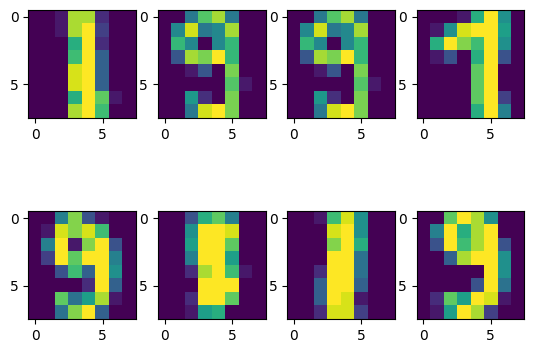

In [7]:
draw_samples(test_x, 8)

In [84]:
dev = qml.device("strawberryfields.fock", wires=4, cutoff_dim=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

def shaper(x):
    """
    x - a single picture
    :param x: an array of pixels
    :return: shape and reshaped array of pixels
    """
    if x.shape[0] == 64:
        return 8, tf.reshape(x, [8, 8])
    elif x.shape[0] == 36:
        return 6, tf.reshape(x, [6, 6])
    elif x.shape[0] == 35:
        return 5, tf.reshape(x, [5, 5])
    elif x.shape[0] == 16:
        return 4, tf.reshape(x, [4, 4])
    elif x.shape[0] == 9:
        return 3, tf.reshape(x, [3, 3])
    elif x.shape[0] == 4:
        return 2, tf.reshape(x, [2, 2])


def make_matrixes(image):

    shape, input = shaper(image)

    matrixes = []

    for j in range(0, shape, 2):
        for k in range(0, shape, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = matrixes.append(
                [
                    input[j, k],
                    input[j, k + 1],
                    input[j + 1, k],
                    input[j + 1, k + 1]
                ]
            )

    return np.array(matrixes)

def conv_2x2_layer(phi):
    for j in range(4):
        qml.Squeezing(1.5, phi[j], wires=j)
        # qml.Rotation(0.5 * phi[j], wires=1)
    
    qml.Beamsplitter(np.pi / 4, 0, wires=[0, 1])
    qml.Beamsplitter(np.pi / 4, 0, wires=[2, 3])

    for j in range(4):
        qml.Rotation(0.5 * phi[j], wires=j)

    qml.Beamsplitter(np.pi / 4, 0, wires = [1, 2])
    qml.Rotation(0.5 * phi[j], wires=1)
    qml.Rotation(0.5 * phi[j], wires=2)

    # return qml.expval(qml.NumberOperator(1)).numeric_type()
    return qml.probs(wires=1).numeric_type()
    # return [qml.expval(qml.NumberOperator(j)) for j in range(4)]

def fc_layer(phi):
    for j in range(4):
        qml.Squeezing(1.5, phi[j], wires=j)

    qml.Beamsplitter(np.pi / 4, 0, wires=[0, 1])
    qml.Beamsplitter(np.pi / 4, 0, wires=[2, 3])

    for j in range(4):
        qml.Rotation(0.5 * phi[j], wires=j)

    qml.Beamsplitter(np.pi / 4, 0, wires = [1, 2])
    qml.Rotation(0.5 * phi[j], wires=1)
    qml.Rotation(0.5 * phi[j], wires=2)

    # return qml.expval(qml.NumberOperator(1)).numeric_type()
    return [qml.probs(wires=1).numeric_type()]
    

@qml.qnode(dev, interface="autograd")
def circuit(images):
    output = []
    for image in images:
        matrixes = make_matrixes(image)

        conv_output = [conv_2x2_layer(phi) for phi in matrixes]
        conv_output = tf.convert_to_tensor(np.array(conv_output), dtype=tf.float32)

        matrixes = make_matrixes(conv_output)

        conv_output = [conv_2x2_layer(phi) for phi in matrixes]

        output.append(fc_layer(conv_output))
        # print('done')
    return output

In [85]:
predictions = circuit(train_x)

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


ValueError: ignored

In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


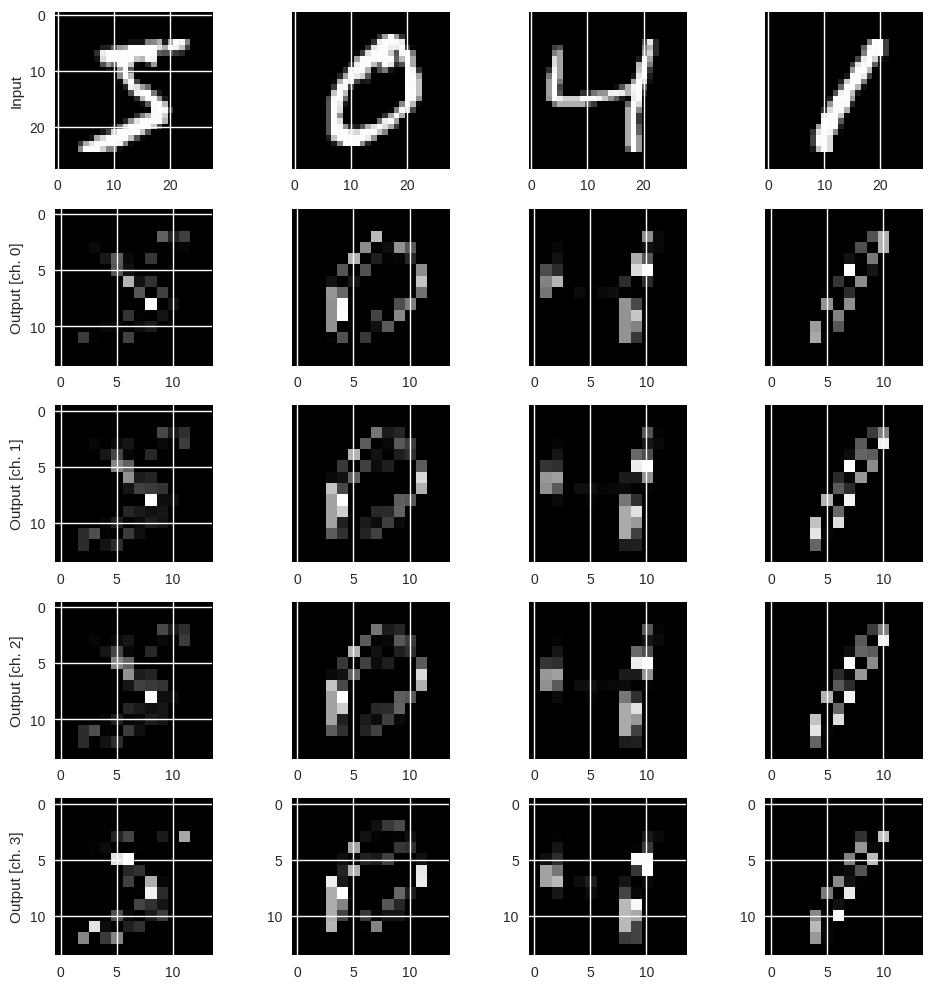

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

Hybrid conv model

In [ ]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [ ]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.3140 - accuracy: 0.1200 - val_loss: 2.2959 - val_accuracy: 0.1333 - 691ms/epoch - 53ms/step
Epoch 2/30
13/13 - 0s - loss: 2.2894 - accuracy: 0.0800 - val_loss: 2.3039 - val_accuracy: 0.0333 - 80ms/epoch - 6ms/step
Epoch 3/30
13/13 - 0s - loss: 2.2824 - accuracy: 0.0800 - val_loss: 2.3141 - val_accuracy: 0.1333 - 70ms/epoch - 5ms/step
Epoch 4/30
13/13 - 0s - loss: 2.2816 - accuracy: 0.0600 - val_loss: 2.3196 - val_accuracy: 0.1333 - 70ms/epoch - 5ms/step
Epoch 5/30
13/13 - 0s - loss: 2.2802 - accuracy: 0.1000 - val_loss: 2.3084 - val_accuracy: 0.1333 - 71ms/epoch - 5ms/step
Epoch 6/30
13/13 - 0s - loss: 2.2808 - accuracy: 0.1200 - val_loss: 2.3152 - val_accuracy: 0.1667 - 75ms/epoch - 6ms/step
Epoch 7/30
13/13 - 0s - loss: 2.2764 - accuracy: 0.1400 - val_loss: 2.3202 - val_accuracy: 0.1667 - 79ms/epoch - 6ms/step
Epoch 8/30
13/13 - 0s - loss: 2.2794 - accuracy: 0.0800 - val_loss: 2.3179 - val_accuracy: 0.1667 - 64ms/epoch - 5ms/step
Epoch 9/30
13/13 - 0s 

In [ ]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.3797 - accuracy: 0.2400 - val_loss: 2.2295 - val_accuracy: 0.3333 - 1s/epoch - 79ms/step
Epoch 2/30
13/13 - 0s - loss: 1.9981 - accuracy: 0.4200 - val_loss: 2.0843 - val_accuracy: 0.3667 - 157ms/epoch - 12ms/step
Epoch 3/30
13/13 - 0s - loss: 1.6991 - accuracy: 0.5400 - val_loss: 1.9500 - val_accuracy: 0.3333 - 104ms/epoch - 8ms/step
Epoch 4/30
13/13 - 0s - loss: 1.4555 - accuracy: 0.7600 - val_loss: 1.8210 - val_accuracy: 0.4000 - 91ms/epoch - 7ms/step
Epoch 5/30
13/13 - 0s - loss: 1.2489 - accuracy: 0.8400 - val_loss: 1.6952 - val_accuracy: 0.4667 - 120ms/epoch - 9ms/step
Epoch 6/30
13/13 - 0s - loss: 1.0816 - accuracy: 0.9200 - val_loss: 1.5971 - val_accuracy: 0.5333 - 97ms/epoch - 7ms/step
Epoch 7/30
13/13 - 0s - loss: 0.9357 - accuracy: 0.9800 - val_loss: 1.5251 - val_accuracy: 0.6000 - 95ms/epoch - 7ms/step
Epoch 8/30
13/13 - 0s - loss: 0.8178 - accuracy: 1.0000 - val_loss: 1.4516 - val_accuracy: 0.6000 - 102ms/epoch - 8ms/step
Epoch 9/30
13/13 - 0

<ipython-input-27-2ae60e937617>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


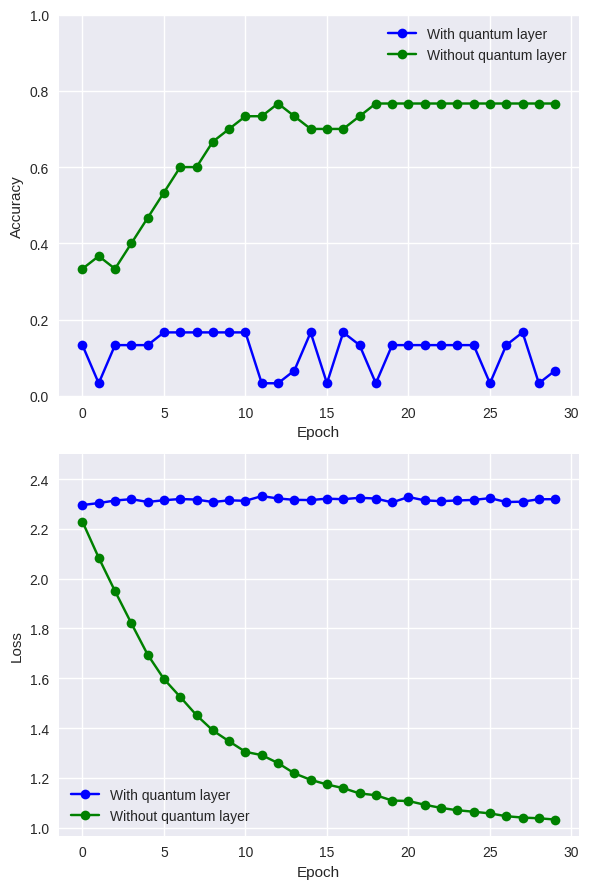

In [ ]:
# import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()